In [2]:
import pandas as pd
import numpy as np
from geohash import encode, decode
from sklearn.cluster import DBSCAN
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
import folium
import shap
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
df = pd.read_csv('./artifacts/clean_df.csv', index_col=0)
# 1. Parse 'destination_lat_lng' into separate lat and lng columns
df['dest_lat'] = round(df['destination_lat_lng'].str.replace('[', '').\
    str.replace(']', '').str.split(',', expand=True)[0].astype(float),6)
df['dest_lng'] = round(df['destination_lat_lng'].str.replace('[', '').\
    str.replace(']', '').str.split(',', expand=True)[1].astype(float),6)
df['day_of_week_n'] = df['day_of_week'].map({'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6})
df.dropna(inplace=True)

In [83]:
corr_matrix = df.select_dtypes(include='number').corr().abs()
corr_matrix = corr_matrix['ted']
corr_matrix.drop('ted', inplace=True)
phase1 = corr_matrix[corr_matrix >= 0.1].index.tolist()

In [84]:
model = XGBRegressor(n_estimators=150)
model.fit(df[phase1], df['ted'])
importances = pd.Series(model.feature_importances_, index=phase1)
importances = importances.sort_values(ascending=False)
cumulative = importances.cumsum() / importances.sum()
phase2 = importances[cumulative <= 1.0].index.tolist()

In [73]:
phase2 = phase2+['distance_km']

In [86]:
# Ensure the input data has the same number of features as the model expects
input_data = df[phase2].values
if input_data.shape[1] != model.n_features_in_:
	raise ValueError(f"Expected {model.n_features_in_} features, but got {input_data.shape[1]} features.")

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(input_data)
avg_shap = pd.Series(np.abs(shap_values).mean(0), index=phase2)
phase3 = avg_shap[avg_shap > 0.05 * avg_shap.max()].index.tolist()

In [87]:
mandatory = ['hour_of_day']
final_features = mandatory + phase3

Text(0.5, 1.0, 'Final Feature Correlations')

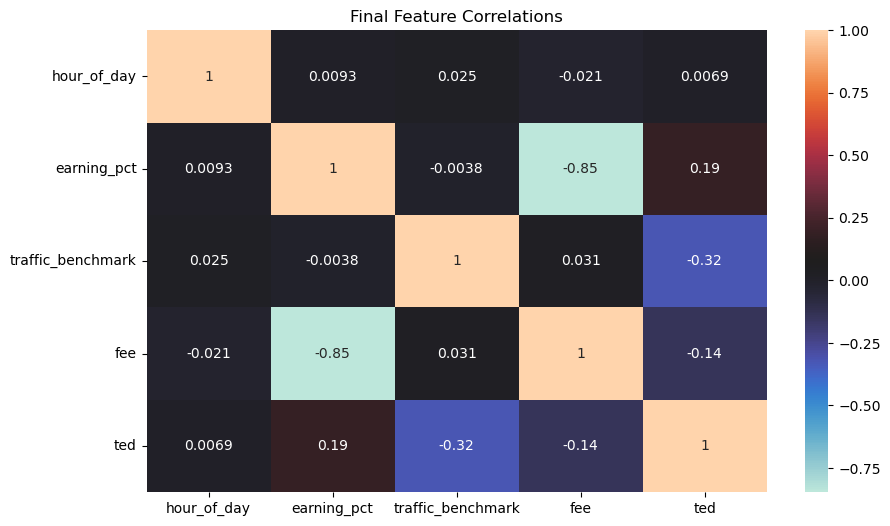

In [88]:
plt.figure(figsize=(10,6))
sns.heatmap(df[final_features+['ted']].corr(), annot=True, cmap='icefire')
plt.title("Final Feature Correlations")

In [89]:
from geohash import encode
precision = 6  # ~0.61km accuracy

df['origin_geohash'] = df.apply(
    lambda x: encode(x['origin_lat'], x['origin_lng'], precision=precision), axis=1)
df['dest_geohash'] = df.apply(
    lambda x: encode(x['dest_lat'], x['dest_lng'], precision=precision), axis=1)

In [170]:
from sklearn.cluster import DBSCAN

coords = df[['origin_lat', 'origin_lng', 'dest_lat', 'dest_lng']]
dbscan = DBSCAN(eps=0.02, min_samples=1)  # ~2km radius
df['route_cluster'] = dbscan.fit_predict(coords)

In [171]:
df['route_cluster'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [172]:
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
le_origin = LabelEncoder()
le_dest = LabelEncoder()
df['origin_geohash_encoded'] = le_origin.fit_transform(df['origin_geohash'])
df['dest_geohash_encoded'] = le_dest.fit_transform(df['dest_geohash'])

model = XGBRegressor(objective='reg:squarederror')
features = final_features + ['route_cluster', 'origin_lat', 'dest_lng']
model.fit(df[features], df['ted'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [135]:
features

['hour_of_day',
 'earning_pct',
 'traffic_benchmark',
 'fee',
 'route_cluster',
 'origin_geohash_encoded',
 'dest_geohash_encoded']

In [176]:
def get_top_routes(hour):
    # Create location grid for prediction
    all_geohashes = df['origin_geohash_encoded'].unique()[:1000]  # Sample for demo
    pass_geohashes = df['origin_geohash'].unique()[:1000]  # Sample for demo
    grid = [(hour,75,3, 25,-1, gh, gh) for gh in all_geohashes]  # Mock surge and cluster
    predictions = model.predict(pd.DataFrame(grid, columns=features))
    return sorted(zip(pass_geohashes, predictions), key=lambda x: -x[1])[:5]

In [179]:
import folium

def plot_optimal_routes(hour):
    m = folium.Map(location=[df['origin_lat'].mean(), 
                            df['origin_lng'].mean()])
    for geohash, score in get_top_routes(hour):
        lat,lng = decode(geohash)
        folium.CircleMarker([lat, lng], radius=score*10,
                           color='green' if score>0.7 else 'orange').add_to(m)
    return m

map = plot_optimal_routes(8)

In [180]:
map

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2541 entries, 0 to 3105
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type                   2541 non-null   object 
 1   date                   2541 non-null   object 
 2   time                   2541 non-null   object 
 3   duration               2541 non-null   object 
 4   distance               2541 non-null   object 
 5   origin                 2541 non-null   object 
 6   destination            2541 non-null   object 
 7   total_earning          2541 non-null   float64
 8   base_fare              2541 non-null   float64
 9   customer_fare          2541 non-null   float64
 10  paid_to_driver         2541 non-null   float64
 11  paid_to_uber           2541 non-null   float64
 12  datetime               2541 non-null   object 
 13  duration_dt            2541 non-null   object 
 14  distance_km            2541 non-null   float64
 15  origin_la